In [1]:
from components.dataset_jo import Dataset_subjectDependent as MyDataset
from components.preprocessing import preprocess_interface, standardize, DE, ASYM, PCC

dataset = MyDataset(dataset_path='data', lazyload=True)
lenght = 12
dataset.set_segment(7680//(128*60))
data, labels, groups = dataset.get_data('all', stimuli=1, return_type='numpy')
# X = DE(data, variant='asd')
# X = standardize(X)

Found: 32 files


In [34]:
from sklearn.model_selection import StratifiedGroupKFold,GridSearchCV,StratifiedKFold
n_split_outter = 10
cv_outter = StratifiedGroupKFold(n_splits=n_split_outter, shuffle=False)
train_1 = list(cv_outter.split(X, labels, groups))

cv_outter_2 = StratifiedGroupKFold(n_splits=n_split_outter, shuffle=False)
train_2 = list(cv_outter_2.split(X, labels, groups))

In [43]:
for a,b in zip(train_1, train_2):
    train = (a[0] == b[0]).all()
    test = (a[1] == b[1]).all()
    print(train == test)

True
True
True
True
True
True
True
True
True
True


In [55]:
import numpy as np
def _calculate_fft(signal, sfreq):
    """ signal: can be 1D array of (n_sample,) or 2D array of (n_signal, n_sample)  """
    # the result will be a complex number. We can obtain the magnitude using `absolute`
    magnitude = np.abs(np.fft.fft(signal, sfreq))
    # scale the result
    magnitude = magnitude / (sfreq/2)
    # Selecting the range
    magnitude = magnitude.T[:sfreq//2].T
    freq_range= np.fft.fftfreq(128, d=1/128)[:128//2]
    return magnitude



In [36]:
from components.preprocessing import convert_to_mne
import mne
epochs = convert_to_mne(data)
epochs = mne.preprocessing.compute_current_source_density(epochs)
data_time = epochs.get_data()  

Fitted sphere radius:         95.3 mm
Origin head coordinates:      -0.8 15.1 45.3 mm
Origin device coordinates:    -0.8 15.1 45.3 mm


(640,)
(1, 1, 64) (64,)
[[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.]]]


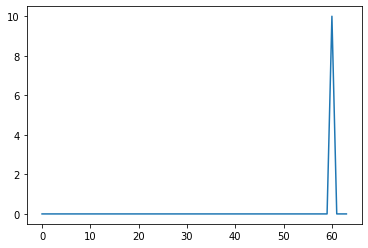

In [56]:
import matplotlib.pyplot as plt
t = np.arange(0,5,1/128)
print(t.shape)
f = 60
data_time = np.sin(t * 2 * np.pi * f).reshape(1,1,-1) * 10

data_freq = _calculate_fft(data_time, 128)

freq_range= np.fft.fftfreq(128, d=1/128)[:128//2]
print(data_freq.shape, freq_range.shape)
plt.plot(freq_range, data_freq[0,0])
data_freq[data_freq < 0.001] = 0
print(data_freq)


In [30]:
np.fft.fftfreq(128, d=1/128)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63., -64., -63.,
       -62., -61., -60., -59., -58., -57., -56., -55., -54., -53., -52.,
       -51., -50., -49., -48., -47., -46., -45., -44., -43., -42., -41.,
       -40., -39., -38., -37., -36., -35., -34., -33., -32., -31., -30.,
       -29., -28., -27., -26., -25., -24., -23., -22., -21., -20., -19.,
       -18., -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,
        -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.])

In [34]:
data.shape, data_time.shape, data_freq.shape

((1280, 32, 7680), (1280, 32, 7680), (1280, 32, 128))

In [11]:
indices = np.array_split(np.arange(data.shape[0]), 1)

In [12]:
indices

[array([    0,     1,     2, ..., 76797, 76798, 76799])]